## Kaggle Diabetic Retinopathy Detection, предобработка изображений

### Севастопольский Артем

In [1]:
import os
import glob
import cv2
import bisect
from collections import deque
from math import sqrt
import importlib
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import skimage
import skimage.morphology, skimage.filters, skimage.feature, skimage.segmentation
import mahotas as mh
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed
from numba import jit
# my library that deals with images and this data set specifically:
from imhandle import load_image, save_image, show_image, rmse, load_set, rgb_to_grayscale

In [2]:
os.path.abspath(os.curdir)

'/home/artem/Programming/Kaggle tasks/Retinopathy/scripts'

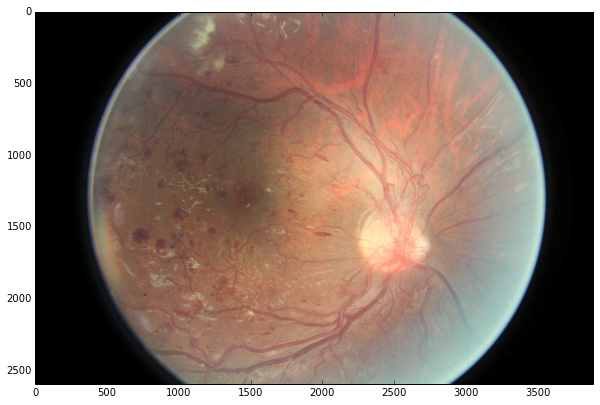

In [211]:
img = load_image('../data/sample/16_left.jpeg')
show_image(img)

In [212]:
img.shape

(2592, 3888, 3)

Разрешение изображения очень высокое, снизим его.

New shape:  (518, 777, 3)


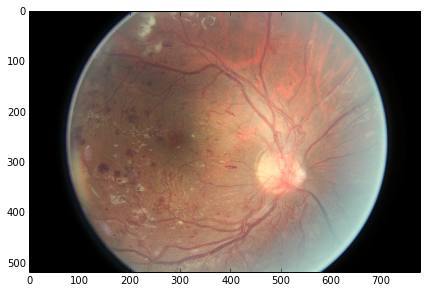

In [213]:
img = sp.misc.imresize(img, 0.2)
show_image(img, fig_size=(7, 7))
print 'New shape: ', img.shape

Уберем черные края.

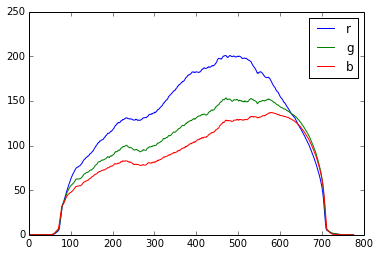

In [6]:
plt.plot(img.mean(axis=0))
plt.legend(list('rgb'))

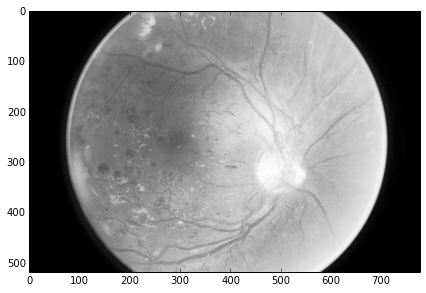

In [214]:
show_image(rgb_to_grayscale(img), fig_size=(7, 7))

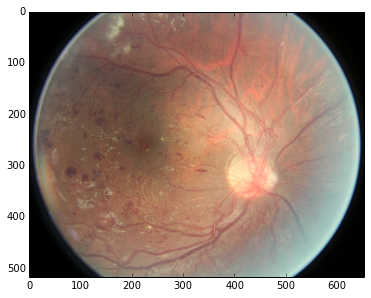

In [6]:
def _non_black_part(distr, ztol=3):
    '''receives vector distr - distribution of pixels over horizontal or vertical axis.
    Returns (a, b): 2 ints that mean that [a, b] part of distr corresponds to image 
    and everything else corresponds to black region.
    '''
    a, b = 0, distr.shape[0] - 1
    while distr[a] < ztol and a < distr.shape[0]:
        a += 1
    while distr[b] < ztol and b >= 0:
        b -= 1
    return (a, b)

def crop_black_border(img):
    gs = rgb_to_grayscale(img)
    distr_hor = gs.mean(axis=0)
    distr_ver = gs.mean(axis=1)
    ver_crop = _non_black_part(distr_hor)
    hor_crop = _non_black_part(distr_ver)
    return img[hor_crop[0]:hor_crop[1], ver_crop[0]:ver_crop[1], :]

crop = crop_black_border(img)
show_image(crop, fig_size=(6, 6))

Можно откадрировать изображение еще сильнее, чтобы совсем убрать черные края.

Функция **crop_by_dist_from_center** принимает изображение центрированного круга глаза и обрезает так, что в изображении остаются только пиксели, удаленные от центра не более чем на frac_radius * radius.

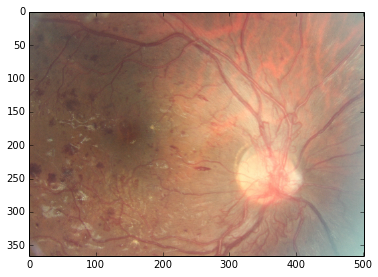

In [21]:
def crop_by_dist_from_center(img, frac_radius=1.0):
    radius = img.shape[0] / 2.0
    height = min(radius, radius * frac_radius / sqrt(2))    # half of side of square inside eye circle
    gap = int(radius - height)
    crop = img[gap:-gap - 1, gap:-gap - 1]
    return crop

full_crop = crop_by_dist_from_center(crop, frac_radius=1.0)
show_image(full_crop, fig_size=(6, 6))

Попробуем вычесть из изображения средний цвет

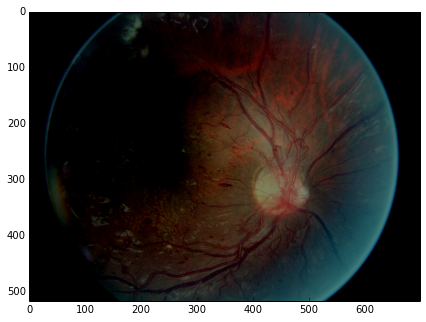

In [608]:
img_shifted = np.maximum(np.minimum(crop - crop.mean(axis=0).mean(axis=0), 255.0), 0.0)
show_image(img_shifted / 255.0, fig_size=(7, 7))

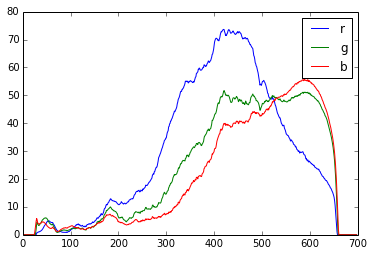

In [609]:
plt.plot(img_shifted.mean(axis=0))
plt.legend(list('rgb'))

При вычитании среднего цвета могла потеряться информация о цвете (отрицательные значения заменены нулем, большие 255 &mdash; 255).

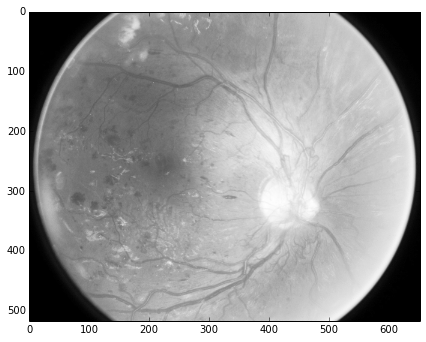

In [8]:
gs = rgb_to_grayscale(crop)
gs_shifted = np.maximum(np.minimum(gs - gs.mean(), 1.0), 0.0)
show_image(gs, fig_size=(7, 7))

### Бинаризация Otsu.

Алгоритм проходит двигающимся окном по изображению и вычисляет в каждой точке порог, отсечением по которому можно разделить объекты переднего и заднего плана. 

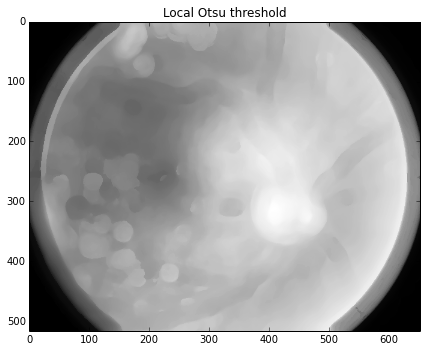

In [180]:
mask = np.full_like(gs, False, dtype=bool)
for i in xrange(gs.shape[0]):
    a, b = _non_black_part(gs[i, :])
    mask[i, a:b] = True

window = skimage.morphology.disk(15)
img_otsu = skimage.filters.rank.otsu(gs / 255.0, window, mask=mask)
show_image(img_otsu, fig_size=(7, 7))
plt.title('Local Otsu threshold')

Пиксели, сильно отличающиеся от порога Otsu:

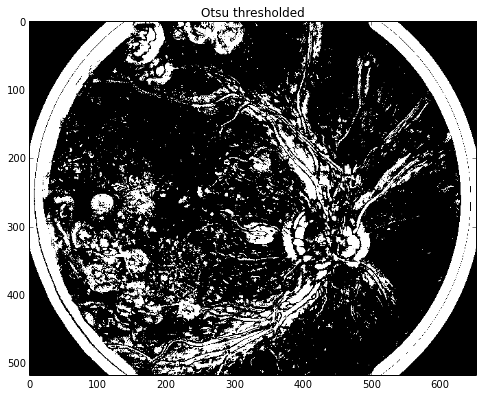

In [181]:
bin_otsu = np.abs(gs - img_otsu) > 10
#bin_otsu = gs > (img_otsu - 2)
show_image(bin_otsu, fig_size=(8, 8))
plt.title('Otsu thresholded')

От картинки выше можно взять **distance transform** &mdash; преобразование изображения, которое в каждой точке устанавливает длину до ближайшего черного пикселя.

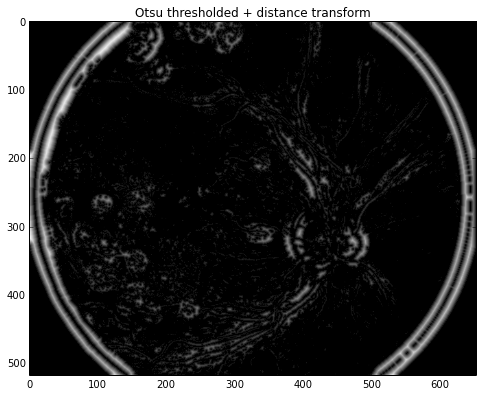

In [182]:
# Applying distance transform
#bin_otsu_distt = mh.distance(1 - bin_otsu)
_, bin_otsu_distt = skimage.morphology.medial_axis(bin_otsu, mask, return_distance=True)
#plt.hist(bin_otsu_distt.ravel(), bins=150)
#bin_otsu_distt = mh.stretch(bin_otsu_distt)
#show_image(bin_otsu_distt, fig_size=(8, 8))
show_image(bin_otsu_distt, fig_size=(8, 8))
plt.title('Otsu thresholded + distance transform')

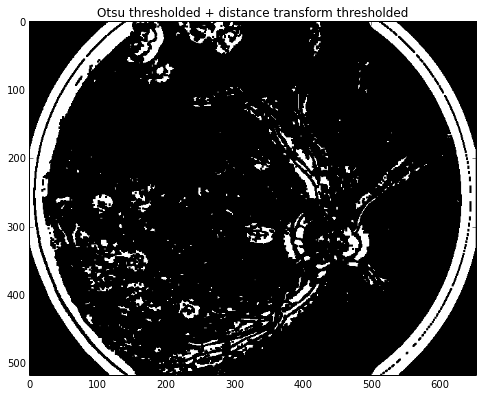

In [183]:
show_image(bin_otsu_distt >= 2, fig_size=(8, 8))
plt.title('Otsu thresholded + distance transform thresholded')

### Бинаризация фильтром Гаусса

Можно попробовать применить к изображению фильтр Гаусса (сделать свертку с фильтром в каждой точке) и посмотреть на пиксели, которые сильно отличается от отклика фильтра.

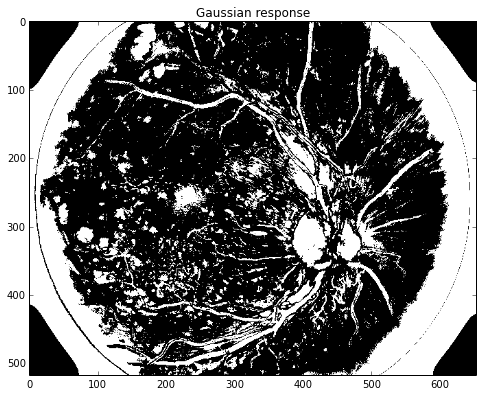

In [184]:
gauss = mh.gaussian_filter(gs, 25)
bin_gauss = np.abs(gs - gauss) > 10
show_image(bin_gauss.astype(int), fig_size=(8, 8))
plt.title('Gaussian response')

Возьмем distance transform от изображения. Отсечем те пиксели, которые удалены мало удалены от черных.

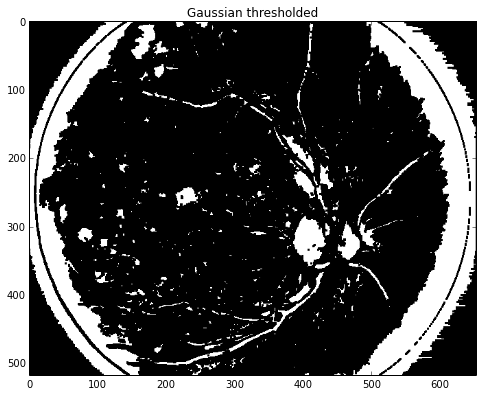

In [185]:
_, bin_gauss_distt = skimage.morphology.medial_axis(bin_gauss, mask, return_distance=True)
show_image(bin_gauss_distt >= 2, fig_size=(8, 8))
plt.title('Gaussian thresholded')

На полученном бинарном изображении есть дефекты, например, присутствует большая область, соответствующая не серому стекловидному телу, а черному пятну, которое есть на изображении любого глаза.

Можно "слить" distance transform полученных изображений в один, если взять поэлементный минимум. Тогда в изображении останутся только пиксели, которые закрашены белыми в обоих изображениях.

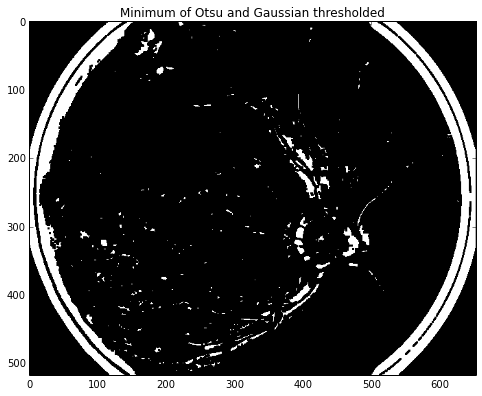

In [186]:
show_image(np.minimum(bin_gauss_distt >= 2, bin_otsu_distt >= 2), fig_size=(8, 8))
plt.title('Minimum of Otsu and Gaussian thresholded')

### Бинаризация медианным фильтром

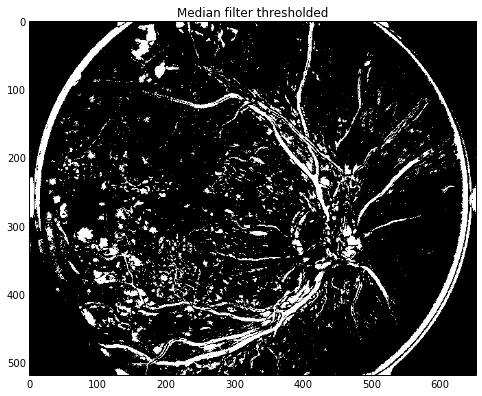

In [190]:
median = mh.median_filter(gs, np.ones((30, 30)))
bin_median = np.abs(gs - median) >= 10
show_image(bin_median.astype(int), fig_size=(8, 8))
plt.title('Median filter thresholded')

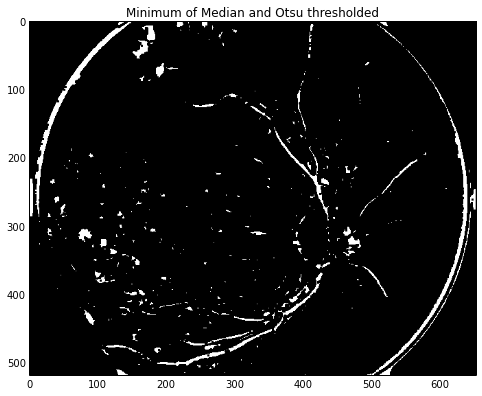

In [191]:
_, bin_median_distt = skimage.morphology.medial_axis(bin_median, mask, return_distance=True)
show_image(bin_median_distt >= 2, fig_size=(8, 8))
plt.title('Minimum of Median and Otsu thresholded')

### Кластеризация на основе обхода в ширину

Можно сегментировать изображение, если провести обход в ширину от каждой точки и добавив в кластер все точки близких цветов.

In [194]:
@jit
def expand(img, ans, row, col, cluster, radius=3, tol=2):
    #ans[row, col] = np.random.randint(0, 255)
    q = deque([(row, col)])
    while q:
        last = q.popleft()
        neighb_row = np.arange(max(last[0] - radius, 0), min(last[0] + radius - 1, img.shape[0]))
        neighb_col = np.arange(max(last[1] - radius, 0), min(last[1] + radius - 1, img.shape[1]))
        for nrow in neighb_row:
            for ncol in neighb_col:
                #print(nrow, ncol)
                if ans[nrow, ncol] == -1 and abs(img[nrow, ncol] - img[row, col]) < tol:
                    ans[nrow, ncol] = cluster
                    q.append((nrow, ncol))

@jit
def bfs_clustered(img, radius=3, tol=2):
    #TODO add mask parameter
    ans = np.full_like(img, -1, dtype=int)
    cluster = 0
    for i in xrange(img.shape[0]):
        for j in xrange(img.shape[1]):
            if ans[i, j] == -1:
                ans[i, j] = cluster
                expand(img, ans, i, j, cluster, radius, tol)
                cluster += 1
    return ans

@jit
def erase_clusters(segm, small_tol=4, large_tol=200, small_replace=-1):
    cl_num = np.zeros(segm.max() + 1)
    ans = segm.copy()
    for i in xrange(segm.shape[0]):
        for j in xrange(segm.shape[1]):
            cl_num[segm[i, j]] += 1
    for i in xrange(segm.shape[0]):
        for j in xrange(segm.shape[1]):
            if cl_num[segm[i, j]] < small_tol or cl_num[segm[i, j]] > large_tol:
                ans[i, j] = small_replace
    return ans

(1785, ' clusters')


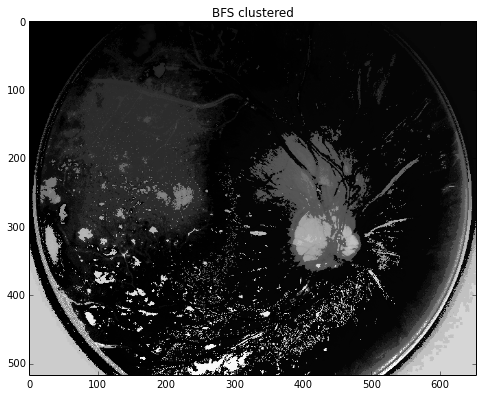

In [207]:
gs_bfs = bfs_clustered(gs, radius=7, tol=5)
show_image(gs_bfs / float(gs_bfs.max()), fig_size=(8, 8))
plt.title('BFS clustered')
print np.unique(gs_bfs.ravel()).size, 'clusters'
#print(gs_bfs)
#print(np.unique(gs_bfs.ravel()))

Удалим слишком малые компоненты (шум) и слишком большие (области около зрачка и темного пятна, фон).

((201,), ' clusters')


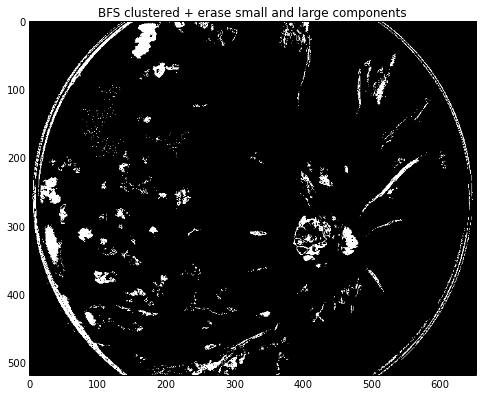

In [206]:
gs_bfs_repl = erase_clusters(gs_bfs, small_tol=20, large_tol=500, small_replace=0)
show_image(gs_bfs_repl != 0, fig_size=(8, 8))
plt.title('BFS clustered + erase small and large components')
print(np.unique(gs_bfs_repl.ravel()).shape, ' clusters')

### Удаление сосудов.

Болезнь характеризуется выделением стекловидного тела, и, похоже, состояние сосудов не зависит от болезни. Попробуем удалить сосуды. Используется оператор лапласиана для поиска границ, отклик лапласиана сравнивается с откликом операции закрытия от лапласиана. Затем производится кластеризация с помощью обхода в ширину, удаляются слишком малые и слишком большие компоненты. Цвета в точках, занятых сосудами, заменяются на средние цвета в окрестностях этих точек.

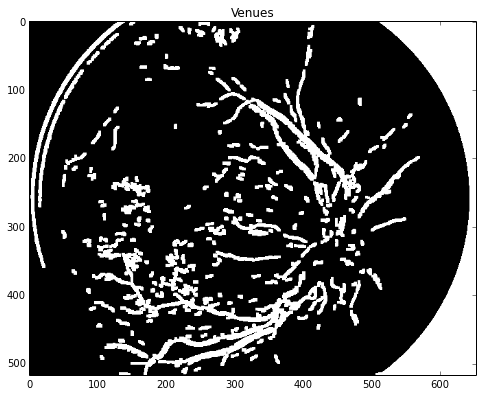

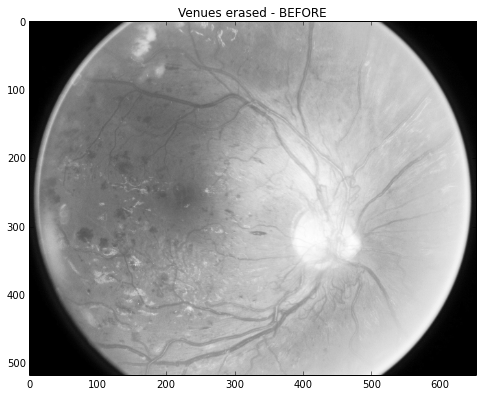

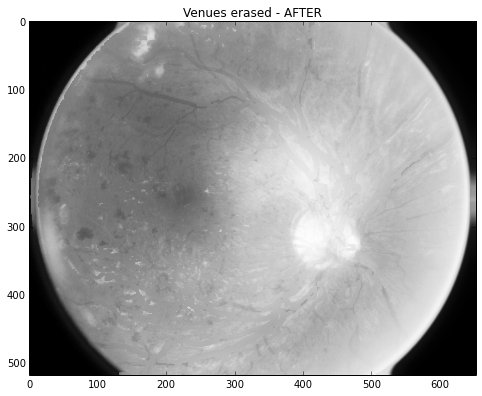

In [149]:
laplacian = cv2.Laplacian(gs.astype(np.uint8), cv2.CV_8U, dst=10, ksize=5, scale=1)
#lapl_median = mh.median_filter(laplacian, Bc=np.ones((10, 10)))
lapl_close = mh.close(laplacian, Bc=np.ones((3, 3)))
#venues = mh.dilate(lapl_close < laplacian, Bc=np.ones((4, 4)))
venues = lapl_close < laplacian

#venues = 1 - mh.close_holes(1 - venues, Bc=np.ones((10, 10)))
#_, venues_distt = skimage.morphology.medial_axis(venues, mask, return_distance=True)
#venues = np.where(venues_distt >= 1, 1, 0)
#venues = mh.dilate(venues, Bc=np.ones((3, 3))) - 1

# bfs segmentation of response
venues_cl = bfs_clustered(venues.astype(int), radius=3, tol=0.5)
venues_cl = erase_clusters(venues_cl, small_tol=8, small_replace=0)
venues = venues_cl != 0

venues = mh.dilate(venues, Bc=np.ones((4, 4)))
show_image(venues, fig_size=(8, 8))
plt.title("Venues")
show_image(gs, fig_size=(8, 8))
plt.title("Venues erased - BEFORE")
gs_nv = np.where(venues, mh.median_filter(gs, np.ones((40, 40))), gs)
show_image(gs_nv, fig_size=(8, 8))    # 'nv' means 'no venues'
plt.title("Venues erased - AFTER")

Попробуем применить к изображению без сосудов выделение ключевых элементов (бинаризация фильтром Гаусса, бинаризация методом Отцу, затем distance transform)

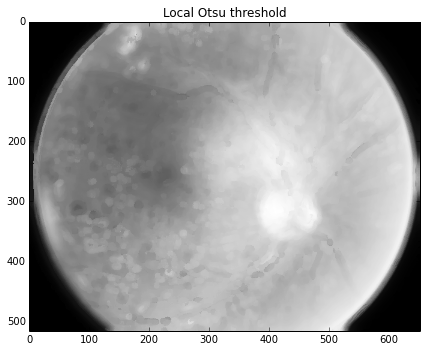

In [170]:
window = skimage.morphology.disk(5)
img_otsu_nv = skimage.filters.rank.otsu(gs_nv / 255.0, window, mask=mask)
show_image(img_otsu_nv, fig_size=(7, 7))
plt.title('Local Otsu threshold')

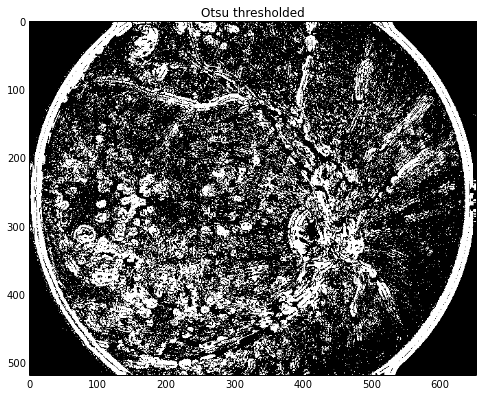

In [171]:
bin_otsu_nv = np.abs(gs_nv - img_otsu_nv) > 4
#bin_otsu_nv = gs_nv > (img_otsu_nv - 2)
show_image(bin_otsu_nv, fig_size=(8, 8))
plt.title('Otsu thresholded')

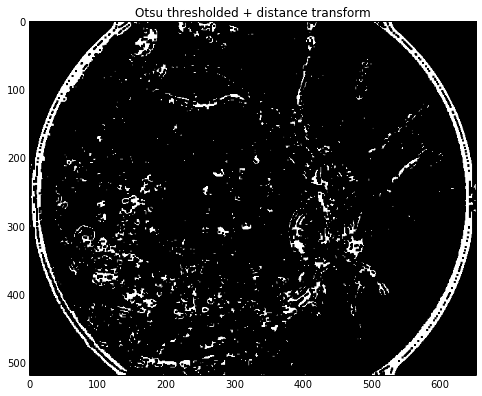

In [172]:
_, bin_otsu_nv_distt = skimage.morphology.medial_axis(bin_otsu_nv, mask, return_distance=True)
show_image(bin_otsu_nv_distt >= 2, fig_size=(8, 8))
plt.title('Otsu thresholded + distance transform')

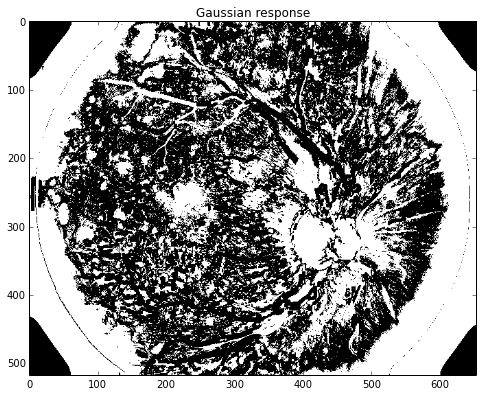

In [209]:
gauss_nv = mh.gaussian_filter(gs_nv, 25)
bin_gauss_nv = np.abs(gs_nv - gauss_nv) > 5
show_image(bin_gauss_nv.astype(int), fig_size=(8, 8))
plt.title('Gaussian response')

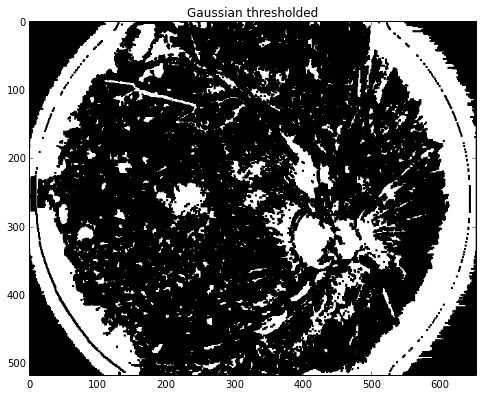

In [176]:
_, bin_gauss_nv_distt = skimage.morphology.medial_axis(bin_gauss_nv, mask, return_distance=True)
show_image(bin_gauss_nv_distt >= 2, fig_size=(8, 8))
plt.title('Gaussian thresholded')

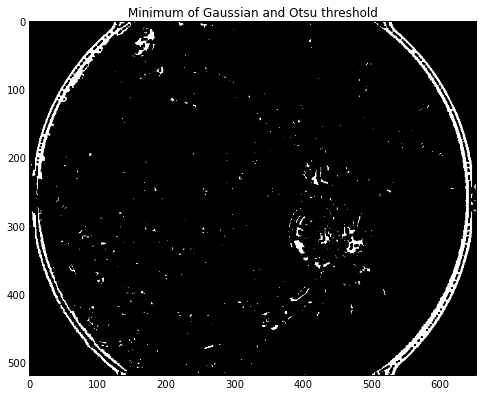

In [178]:
show_image(np.minimum(bin_gauss_nv_distt >= 2, bin_otsu_nv_distt >= 2), fig_size=(8, 8))
plt.title('Minimum of Gaussian and Otsu threshold')

#### Выводы
* Можно сделать предположение, что степень развития болезни определяется выделениями стекловидного тела. На картинках это серые вытянутые круги, похожие на блики. Видимо, они находятся на передней поверхности глаза, т.к. кажутся ближе других объектов.
* Можно бинаризовать изображения с помощью метода бинаризации Отцу или использования фильтров (например, гауссовского), затем отсечь по значению distance transform, чтобы убрать шум. Однако результат сильно зависит от порога: на изображении может остаться много шума или, наоборот, мало необходимых элементов.
* Похоже, удается хорошо бинаризовать изображения с помощью BFS (обхода в ширину). Изображения сегментируются, затем удаляются слишком малые и слишком большие кластеры.
* Можно удалять сосуды с изображения. Однако при сегментации с помощью BFS многие сосуды убираются сами после отсечения по размеру кластеров. 

#### Заметки
* Наверное, вместе с сосудами стоит удалять зрачок и темное пятно.
* Т.к. болезнь определяется по стекловидному телу, которое сильнее отражает свет (это заметно на исходных картинках), хотелось бы попробовать каким-то образом находить объекты, в которых сильнее отражается свет. Модель ICA (Independent Component Analysis) позволяет представить изображение в виде суммы изображения бликов/отражений и остальных объектов: http://www.cs.dartmouth.edu/farid/downloads/publications/cvpr99.pdf, но метод в статье требует не один, а два снимка с разных углов.

**Планы на будущее**

* Белые (и черные!) выделения - это, наверное, самое важное, но сосуды, яркое белое пятно и черное пятно тоже важны.
* Что надо сделать (на каникулах / в начале след. семестра): сделать подвыборку похожих по освещению картинок (может быть, придумать, как это сделать автоматически), сделать признаки (например, Perimeter^2 / Square - характеризует извилистость формы), обучить классификатор. Пока можно делать просто бинарную классификацию.
* Л.М. кинул на почту статью об этой задаче
* Уголок на краю картинки показывает, левый глаз или правый и снимают сверху или снизу.